In [1]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import json
import pandas as pd
from matplotlib.patches import Patch
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':'Arial'})
rc('text',usetex=True)

In [8]:
tax_order = {}
tax_fam = {}
common = {}
latin = {}
phylo = {}
phylo_rev = {}
neat = {}
length = {}

with open('Metadata') as file1:
    for line in file1:
        dat = line.strip().split('\t')
        if not line.startswith('#'):
            # Names and taxonomic data
            common[dat[0]] = dat[2].capitalize()
            latin[dat[0]] = dat[1]
            tax_order[dat[0]] = dat[17]
            tax_fam[dat[0]] = dat[18]

            # If NEAT1 is predicted
            if dat[3] == '1':
                neat[dat[0]] = ''
                length[dat[0]] = int(dat[5])

            if dat[14] == '1':
                phylo[dat[13]] = dat[0]
                phylo_rev[dat[0]] = dat[13]
                

### Make a dictionary with pairwise ANI from BLAST result

In [2]:
#to del
order = sorted(length.keys(), key=lambda kv: length[kv],reverse=True)
print(order[:10])

['GCA_028551375.1_Tremarctos_ornatus_HiC', 'GCA_011680675.1_LBP_v1', 'GCF_002099425.1_phaCin_unsw_v4.1', 'GCF_900497805.2_bare-nosed_wombat_genome_assembly', 'GCF_011100635.1_mTriVul1.pri', 'GCA_016696395.1_USYD_AStu_M', 'GCA_016432865.2_AdamAnt_v2', 'GCA_028533205.1_Lagorchestes_hirsutus_HiC', 'GCA_028646595.1_pg-2k', 'GCA_028372415.1_mMacEug1.pri']


In [3]:
# Parsing BLAST result all vs all
d = {i:{} for i in length}
#name1 and name2 taken from the first line of the blast file (query-subject)
name1 = 'Marsupials_NEAT1'
name2 = 'Marsupials_NEAT1'
l1 = [0 for i in range(length[name1])]
l2 = [0 for i in range(length[name2])]
with open('./BLAST_all_vs_all/NEAT1_all_vs_all.txt') as file1:
    for line in file1:
        dat = line.strip().split('\t')
        if dat[0] == name1 and dat[1] == name2:
            pass
        else:
            ani = (sum(l1)/length[name1] + sum(l2)/length[name2]) / 2
            d[name1][name2] = ani
            name1 = dat[0]
            name2 = dat[1]
            l1 = [0 for i in range(length[name1])]
            l2 = [0 for i in range(length[name2])]
        if int(dat[2]) > 100:
            coor1 = int(dat[4]) - 1
            coor2 = int(dat[5])
            for i in range(coor1,coor2):
                if l1[i] == 0:
                    l1[i] = float(dat[3])
            coor1 = int(dat[6]) - 1
            coor2 = int(dat[7]) - 1
            if coor2 > coor1:
                for i in range(coor1,coor2+1):
                    if l2[i] == 0:
                        l2[i] = float(dat[3])
            else:
                for i in range(coor2,coor1+1):
                    if l2[i] == 0:
                        l2[i] = float(dat[3])              
#If there were no blast matches, add zeros
for item in length:
    for item2 in length:
        if item2 not in d[item]:
            d[item][item2] = 0
json.dump(d, open("./BLAST_all_vs_all/NEAT1_ANI.json","w"))

### Plot heatmaps

In [79]:
d = json.load(open("./BLAST_all_vs_all/NEAT1_ANI.json","r"))
dMalat = json.load(open("./BLAST_all_vs_all/MALAT1_ANI.json","r"))

In [13]:
#Species ordered along phylogenetic tree
tree_order = []
with open('./PhyloTree/leaves_order_all_tree') as file1:
    for line in file1:
        if len(line) > 1:
            tree_order.append(line.strip())

orderAllNeat = [phylo[i] for i in tree_order if i in phylo and phylo[i] in neat][::-1]
orderAllMalat = [phylo[i] for i in tree_order if i in phylo and phylo[i] in malat][::-1]
orderRodentia = [phylo[i] for i in tree_order if i in phylo and phylo[i] in neat and 
                 tax_order[phylo[i]].upper() == 'RODENTIA'][::-1]
orderArchetypes = ['GCF_015852505.1_mTacAcu1.pri', 'GCF_016433145.1_AgileGrace', 'GCA_016432865.2_AdamAnt_v2',
         'GCF_000313985.2_ASM31398v2', 'GCA_000152225.2_Pcap_2.0', 'GCF_014898055.1_MPIMG_talOcc4',
         'GCF_000296755.1_EriEur2.0', 'GCA_029834395.2_SorCin_2.1', 'Human_NEAT1', 'GCA_013371645.1_OryCun3.0',
         'GCF_014633375.1_OchPri4.0', 'GCF_020740685.1_mJacJac1.mat.Y.cur', 'GCA_023101885.1_KIZ_TCIN_v1.0',
         'Mouse_NEAT1','GCF_019054845.1_ASM1905484v1', 'GCA_004027875.1_AplRuf_v1_BIUU']

In [14]:
color_map = {'Monotremata': '#9ecaf1', 'Proboscidea': '#5d8445', 'Microbiotheria': '#9faa4a', 'Dasyuromorphia': '#e7b629',
 'Pilosa': '#f38603', 'Cingulata': '#e92b09', 'Tubulidentata': '#823d02', 'Diprotodontia': '#2dbcb6', 
 'NA': '#c18d44', 'Artiodactyla': '#619ed6', 'Dermoptera': '#475d0a', 'Sirenia': '#c93a00', 
 'Didelphimorphia': '#75a279', 'Lagomorpha': '#b9c53b', 'Rodentia': '#f7d027', 'Macroscelidea': '#a790aa',
 'Scandentia': '#6782c5', 'Eulipotyphla': '#007b9c', 'Chiroptera': '#b77ea3',
 'Pholidota': '#26aefa', 'Primates': '#6ba547', 'Perissodactyla': '#6a8a7f', 'Carnivora': '#e48f1b',
            'Hyracoidea':'#51A6A3', 'Afrosoricida':'#7c98ec',
            'Pedetidae': '#9ecaf1', 'Dipodidae': '#e92b09', 'Platacanthomyidae': '#9faa4a', 'Nesomyidae': '#e7b629',
           'Cricetidae': '#f38603', 'Muridae': '#5d8445', 'Spalacidae': '#823d02', 'Castoridae': '#2dbcb6',
           'Heteromyidae': '#c88e9d', 'Geomyidae': '#5dde50', 'Gliridae': '#475d0a', 'Sciuridae': '#018de5',
           'Aplodontiidae': '#75a279', 'Ctenodactylidae': '#b9c53b', 'Hystricidae': '#62aee8', 
           'Bathyergidae': '#a790aa', 'Thryonomyidae': '#6782c5', 'Petromuridae': '#007b9c', 
           'Cuniculidae': '#c93a00', 'Dasyproctidae': '#26aefa', 'Caviidae': '#52961d', 'Hydrochaeridae': '#6a8a7f',
           'Erethizontidae': '#8ae389', 'Capromyidae': '#c18d44', 'Octodontidae': '#b6b08e',
           'Chinchillidae': '#b86312', 'Dinomyidae': '#fbd700'}

In [65]:
def MakeDataForHeatmap(order,taxon='order'):
    #Make a matrix with ANI vales for heatmap
    m = []
    for item in order:
        l = [d[item][i] for i in order]
        m.append(l)
    matrix = np.array(m)

    # Species names, ordered
    latin_list = [latin[i] for i in order]
    names_list = [common[i] for i in order]

    #Prepare colors for heatmap
    if taxon == 'order':
        uniqSet = set([tax_order[i].capitalize() for i in order])
        taxa_color = [color_map[tax_order[i].capitalize()] for i in order]
        taxa_legend = {i:color_map[i] for i in uniqSet}
        ordersList = [tax_order[i] for i in order]

    elif taxon == 'family':
        uniqSet = set([tax_fam[i].capitalize() for i in order])
        taxa_color = [color_map[tax_fam[i].capitalize()] for i in order]
        taxa_legend = {i:color_map[i] for i in uniqSet}
        ordersList = [tax_fam[i] for i in order]

    #To order legend depending on how many orthologs per taxa, top down

    ordersDict = {i:ordersList.count(i) for i in set(ordersList)}
    taxa_ordered = sorted(ordersDict.keys(), key=lambda x: ordersDict[x],reverse=True)
    return(matrix,latin_list, names_list, taxa_color, taxa_legend,taxa_ordered)

In [71]:
matrix,latin_list, names_list, taxa_color, taxa_legend,taxa_ordered = MakeDataForHeatmap(orderArchetypes)

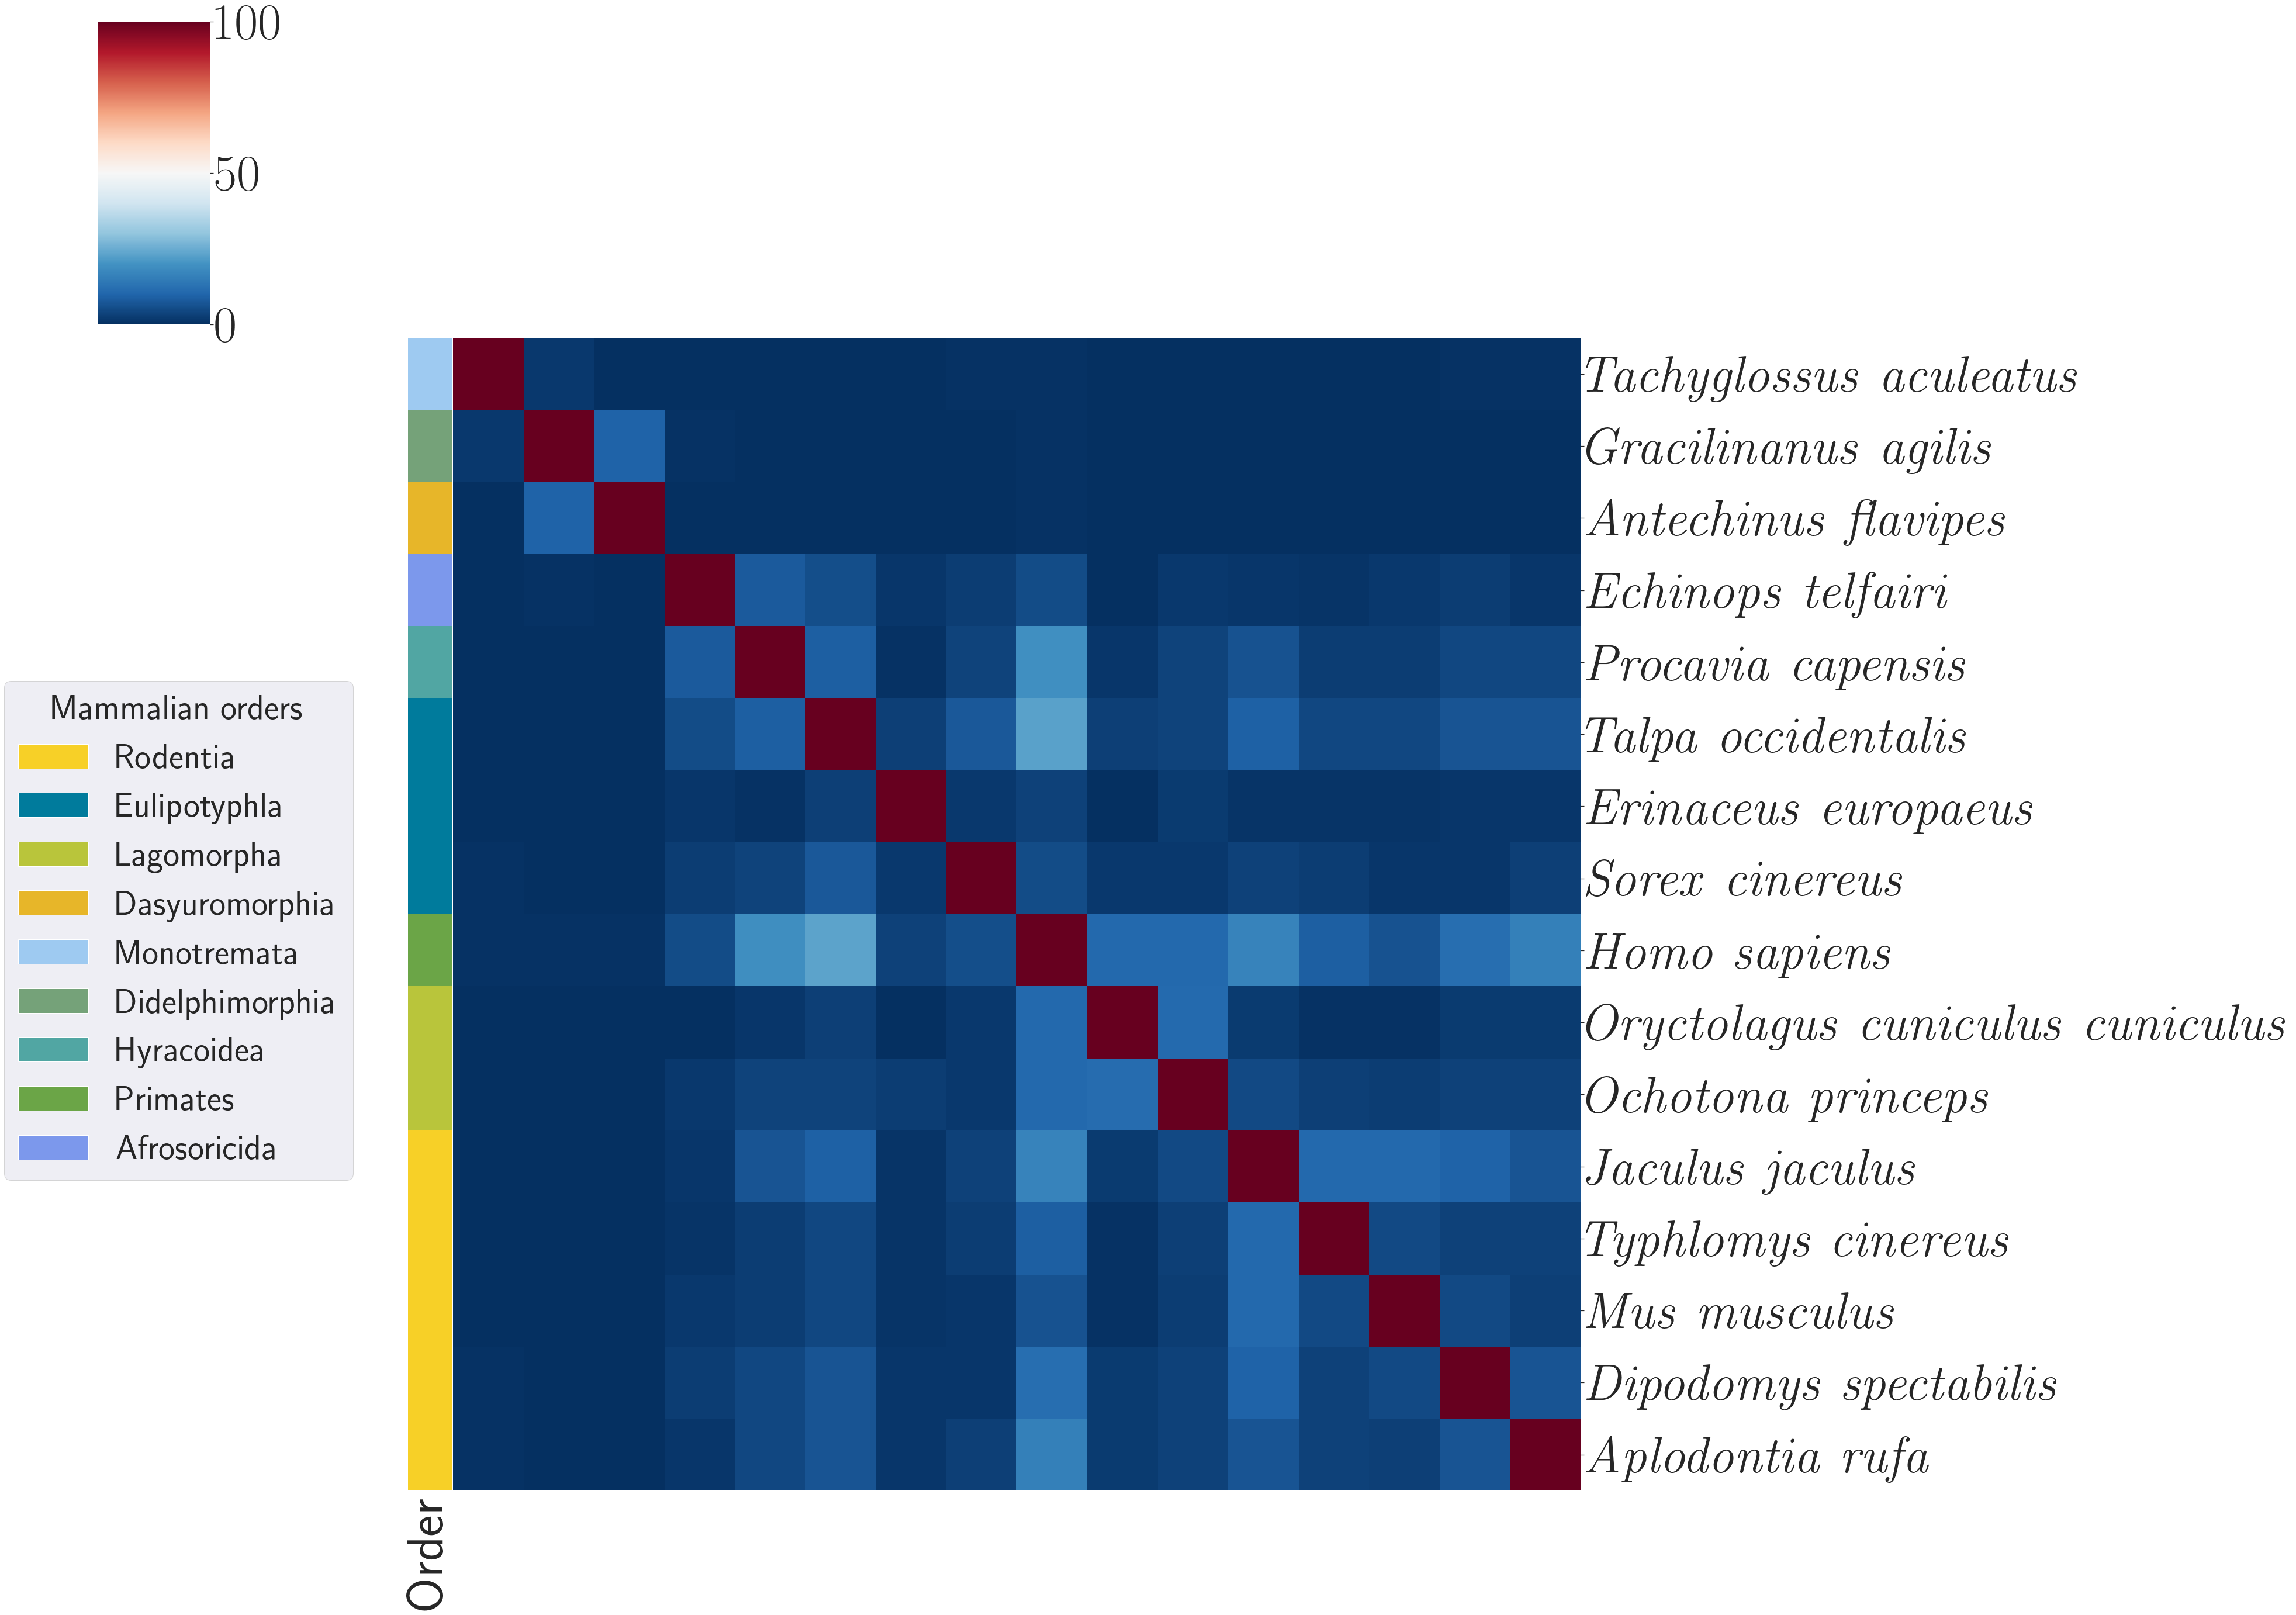

In [73]:
df = pd.DataFrame(matrix)
df_bar = pd.DataFrame([taxa_color]).transpose()
df_bar.set_index = df.columns
df_bar.columns = ['Order']
seaborn.set(font_scale=8)
ans = seaborn.clustermap(df,row_cluster=False,col_cluster=False,cmap='RdBu_r',
               annot_kws={"size": 240}, figsize=(53,40), xticklabels=[], yticklabels=latin_list,
                         row_colors=df_bar)
ans.ax_heatmap.set_yticklabels([r'$\it{' + ticklabel.get_text().replace(' ', '\\ ') + '}$'
                              for ticklabel in ans.ax_heatmap.get_yticklabels()])
ans.ax_row_dendrogram.set_visible(False)
handles1 = [Patch(facecolor=taxa_legend[name]) for name in taxa_ordered]
plt.legend(handles1, taxa_ordered, bbox_to_anchor=(-1,-2),title='Mammalian orders', loc='center left',
          fontsize=60, title_fontsize=60)


In [74]:
ans.savefig('./FiguresPublication/NEAT1_ANI_Archetypes.pdf', dpi=300)

In [66]:
matrix,latin_list, names_list, taxa_color, taxa_legend,taxa_ordered = MakeDataForHeatmap(orderRodentia,'family')

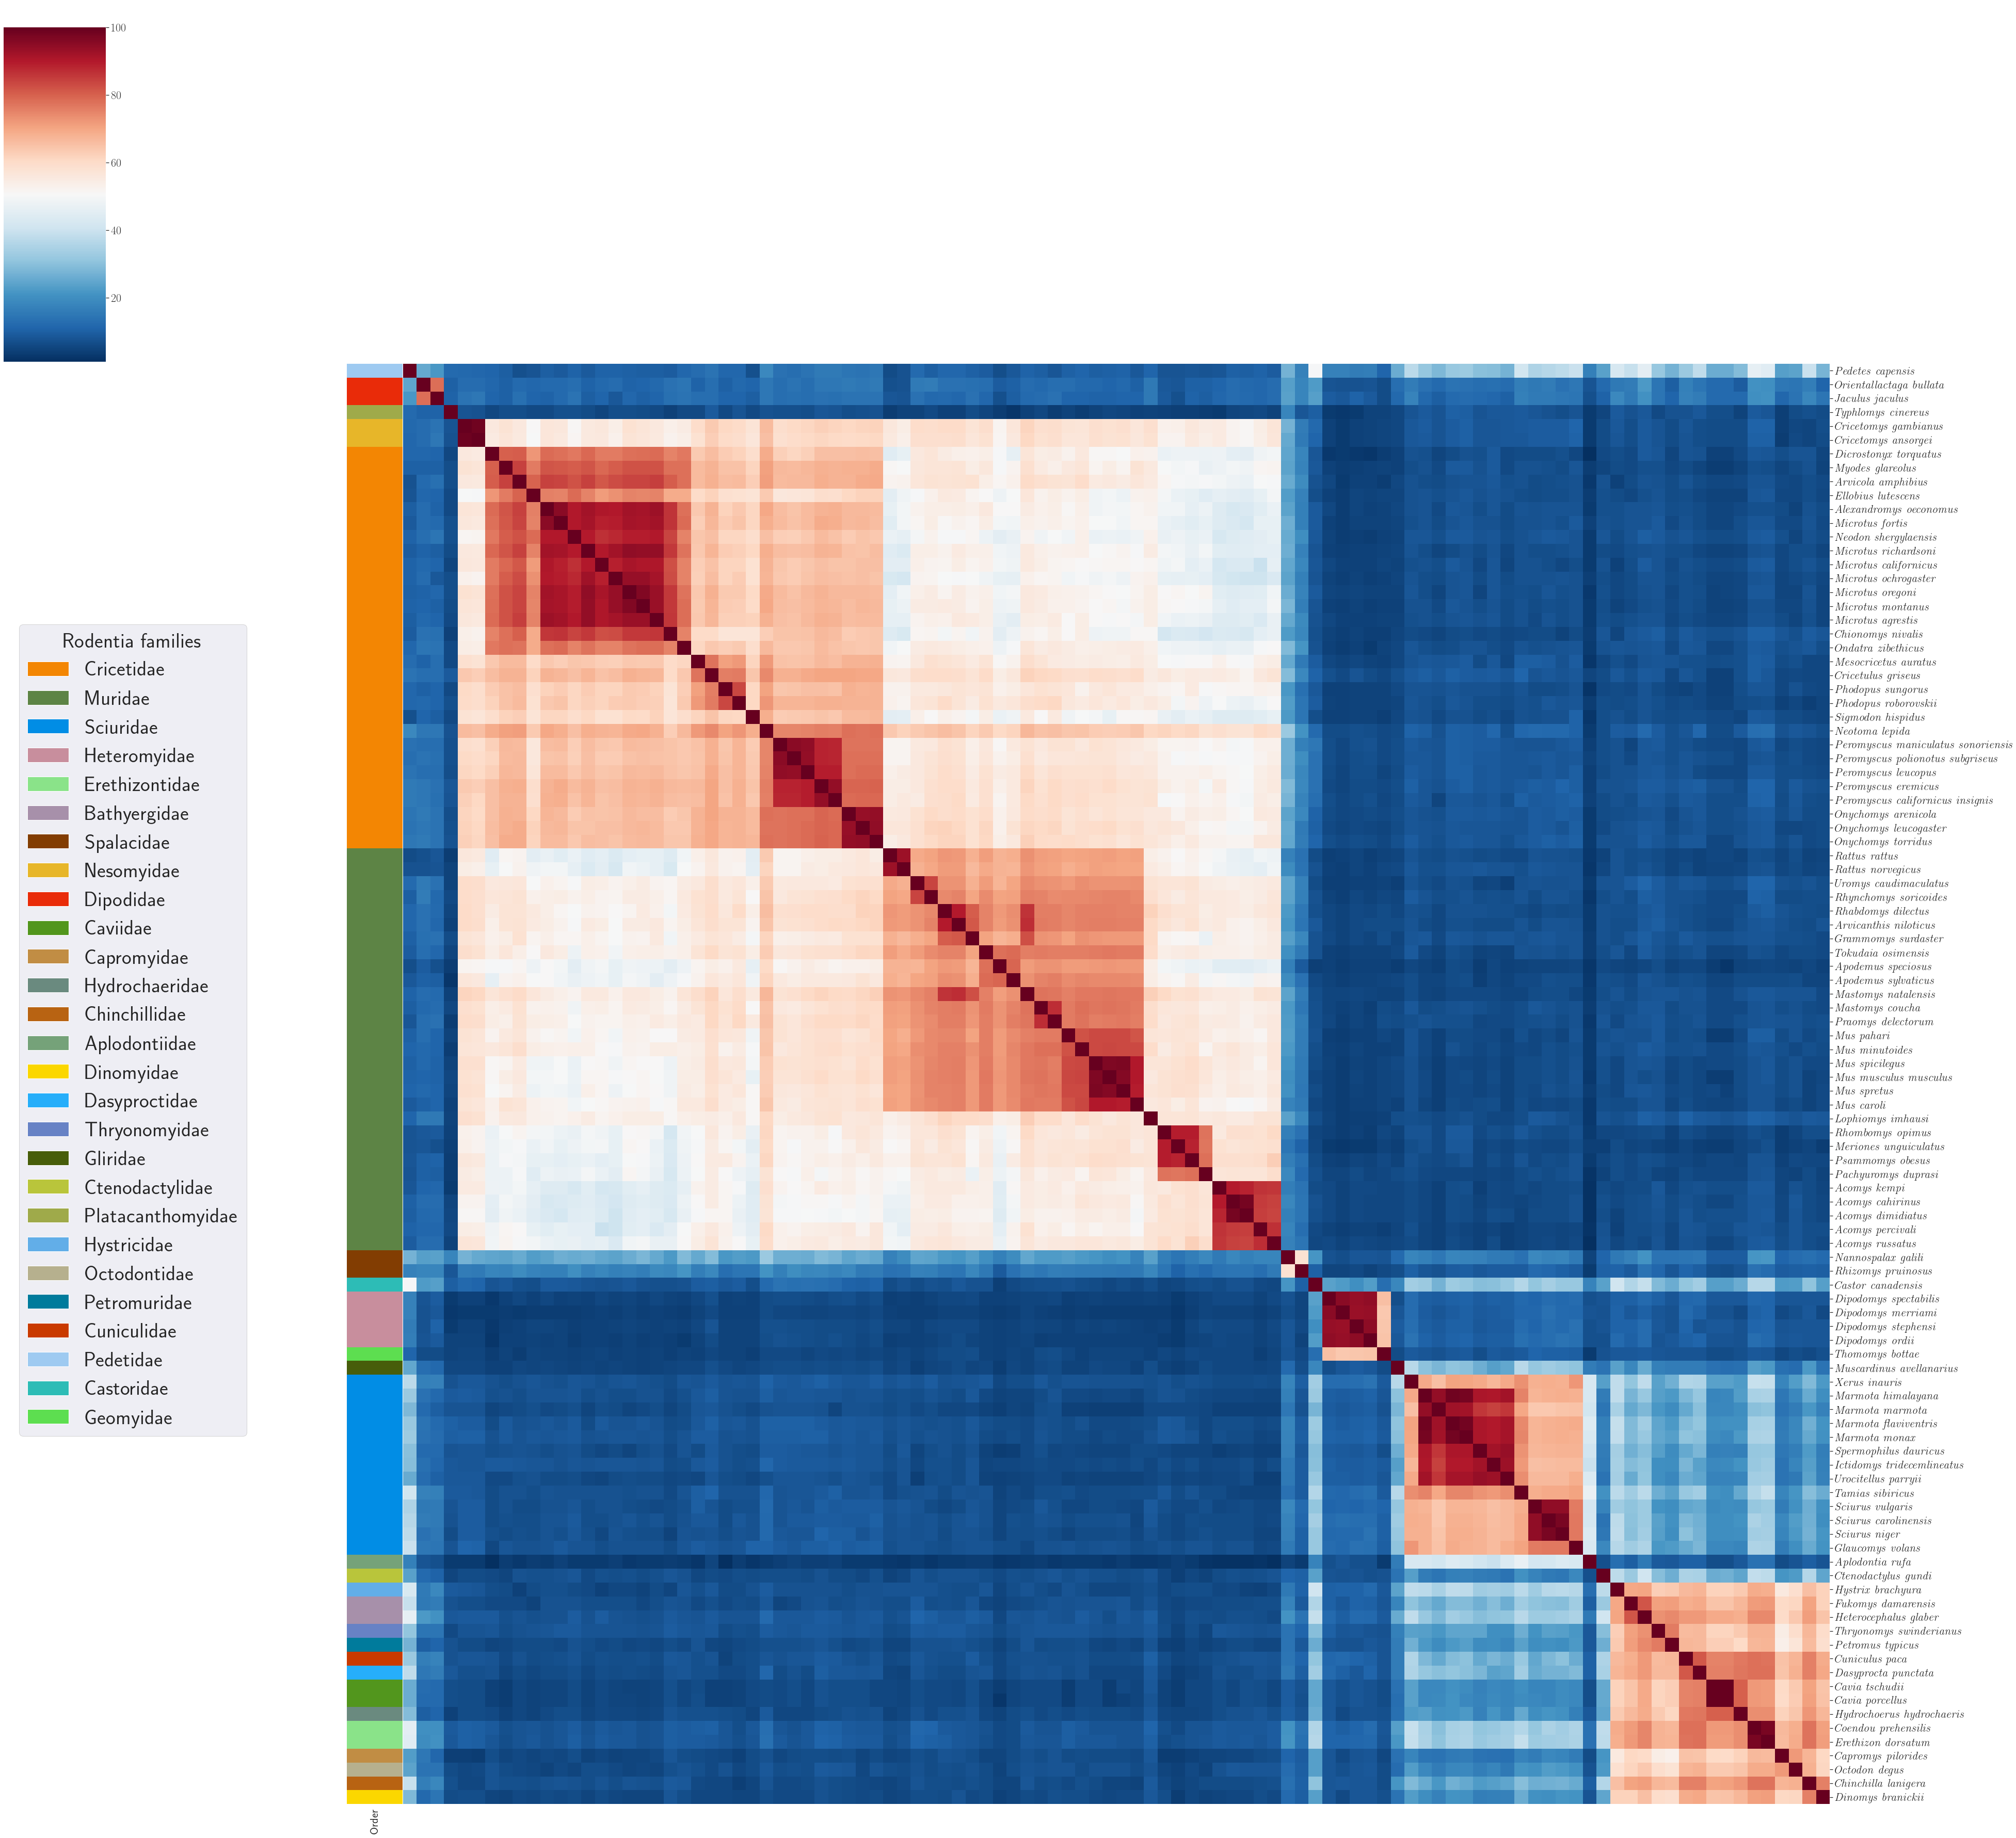

In [69]:
df = pd.DataFrame(matrix)
df_bar = pd.DataFrame([taxa_color]).transpose()
df_bar.set_index = df.columns
df_bar.columns = ['Order']
seaborn.set(font_scale=2)
ans = seaborn.clustermap(df,row_cluster=False,col_cluster=False,cmap='RdBu_r',
               annot_kws={"size": 140}, figsize=(55,50), xticklabels=[], yticklabels=latin_list,
                         row_colors=df_bar)
ans.ax_heatmap.set_yticklabels([r'$\it{' + ticklabel.get_text().replace(' ', '\\ ') + '}$'
                              for ticklabel in ans.ax_heatmap.get_yticklabels()])
ans.ax_row_dendrogram.set_visible(False)
handles1 = [Patch(facecolor=taxa_legend[name]) for name in taxa_ordered]
plt.legend(handles1, taxa_ordered, bbox_to_anchor=(0.05, -2),title='Rodentia families', loc='center left',
          fontsize=40, title_fontsize=40)



In [70]:
ans.savefig('./FiguresPublication/NEAT1_ANI_Rodentia.pdf', dpi=300)

In [75]:
matrix,latin_list, names_list, taxa_color, taxa_legend,taxa_ordered = MakeDataForHeatmap(orderAllNeat)

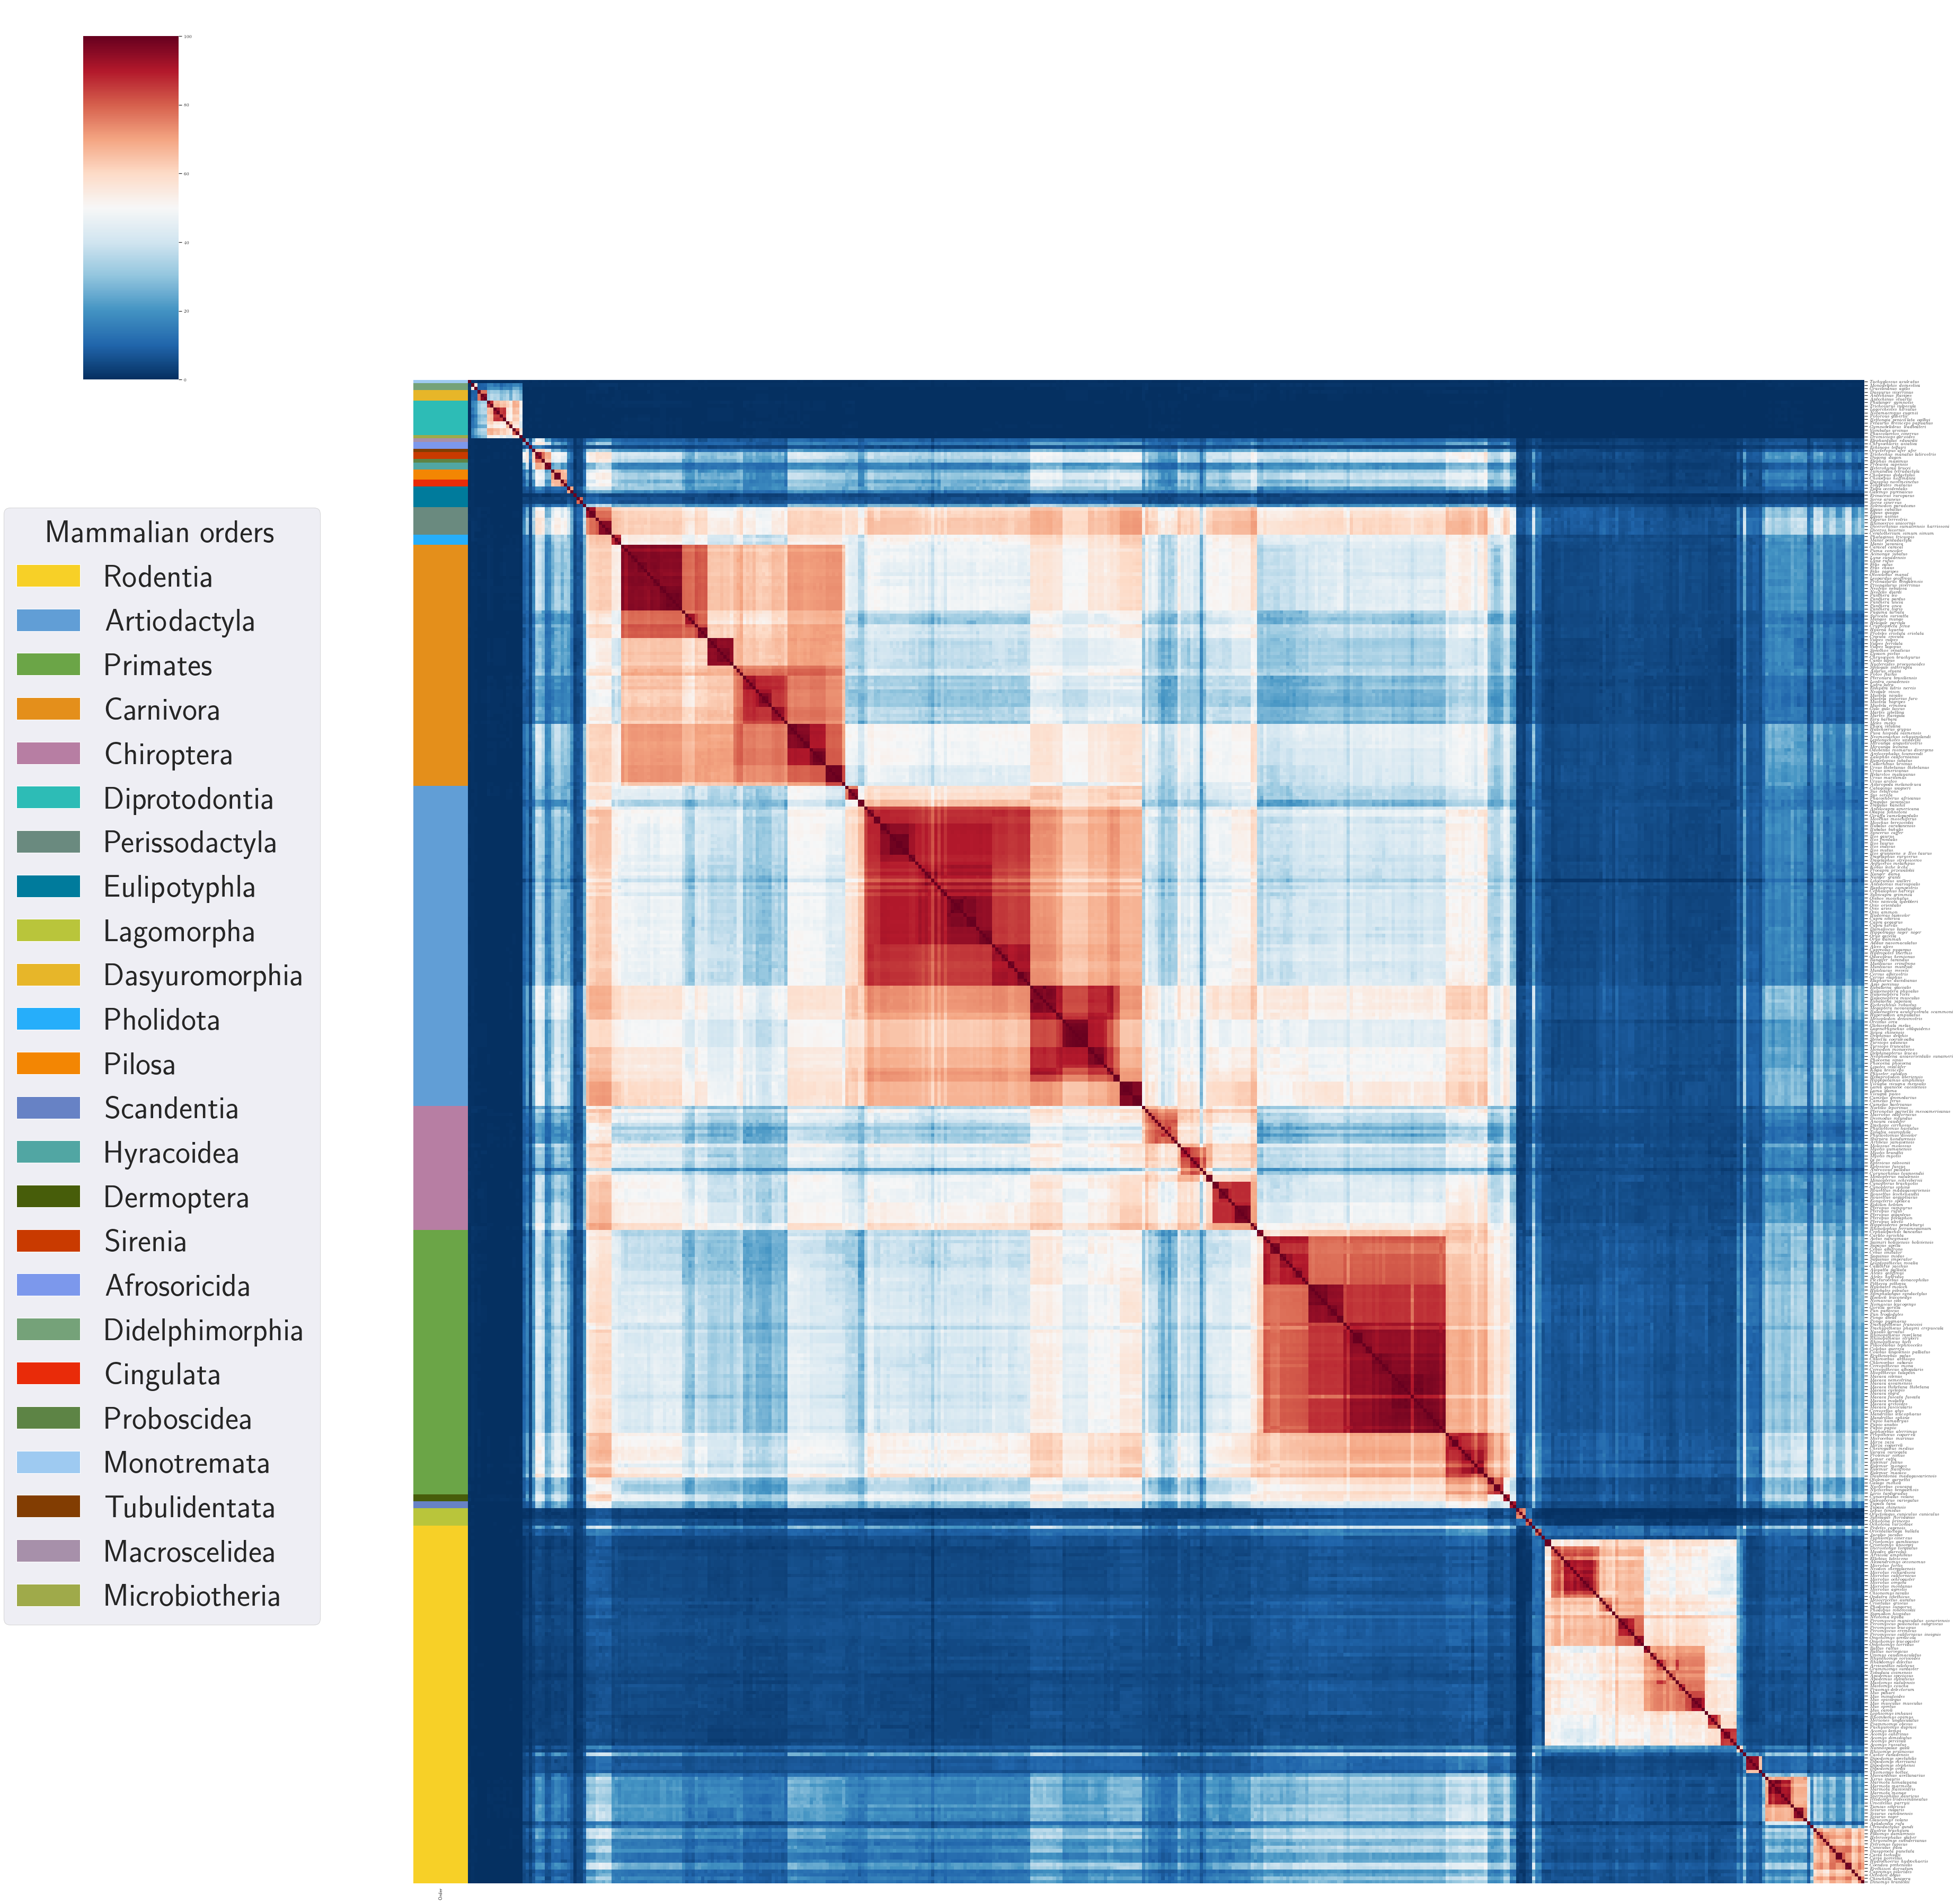

In [76]:
df = pd.DataFrame(matrix)
df_bar = pd.DataFrame([taxa_color]).transpose()
df_bar.set_index = df.columns
df_bar.columns = ['Order']
seaborn.set(font_scale=0.8)
ans = seaborn.clustermap(df,row_cluster=False,col_cluster=False,cmap='RdBu_r',
               annot_kws={"size": 80}, figsize=(50,50), xticklabels=[], yticklabels=latin_list,
                         row_colors=df_bar)
ans.ax_heatmap.set_yticklabels([r'$\it{' + ticklabel.get_text().replace(' ', '\\ ') + '}$'
                              for ticklabel in ans.ax_heatmap.get_yticklabels()])
ans.ax_row_dendrogram.set_visible(False)
handles1 = [Patch(facecolor=taxa_legend[name]) for name in taxa_ordered]
plt.legend(handles1, taxa_ordered, bbox_to_anchor=(-1,-2),title='Mammalian orders', loc='center left',
          fontsize=60, title_fontsize=60)




In [77]:
ans.savefig('./FiguresPublication/NEAT1_ANI_along_phylotree.pdf', dpi=300)

In [80]:
order = orderAllMalat
m = []
for item in order:
    l = [dMalat[item][i] for i in order]
    m.append(l)
matrix = np.array(m)

# Species names, ordered
latin_list = [latin[i] for i in order]
names_list = [common[i] for i in order]

#Prepare colors for heatmap

uniqSet = set([tax_order[i].capitalize() for i in order])
taxa_color = [color_map[tax_order[i].capitalize()] for i in order]
taxa_legend = {i:color_map[i] for i in uniqSet}
ordersList = [tax_order[i] for i in order]

#To order legend depending on how many orthologs per taxa, top down

ordersDict = {i:ordersList.count(i) for i in set(ordersList)}
taxa_ordered = sorted(ordersDict.keys(), key=lambda x: ordersDict[x],reverse=True)


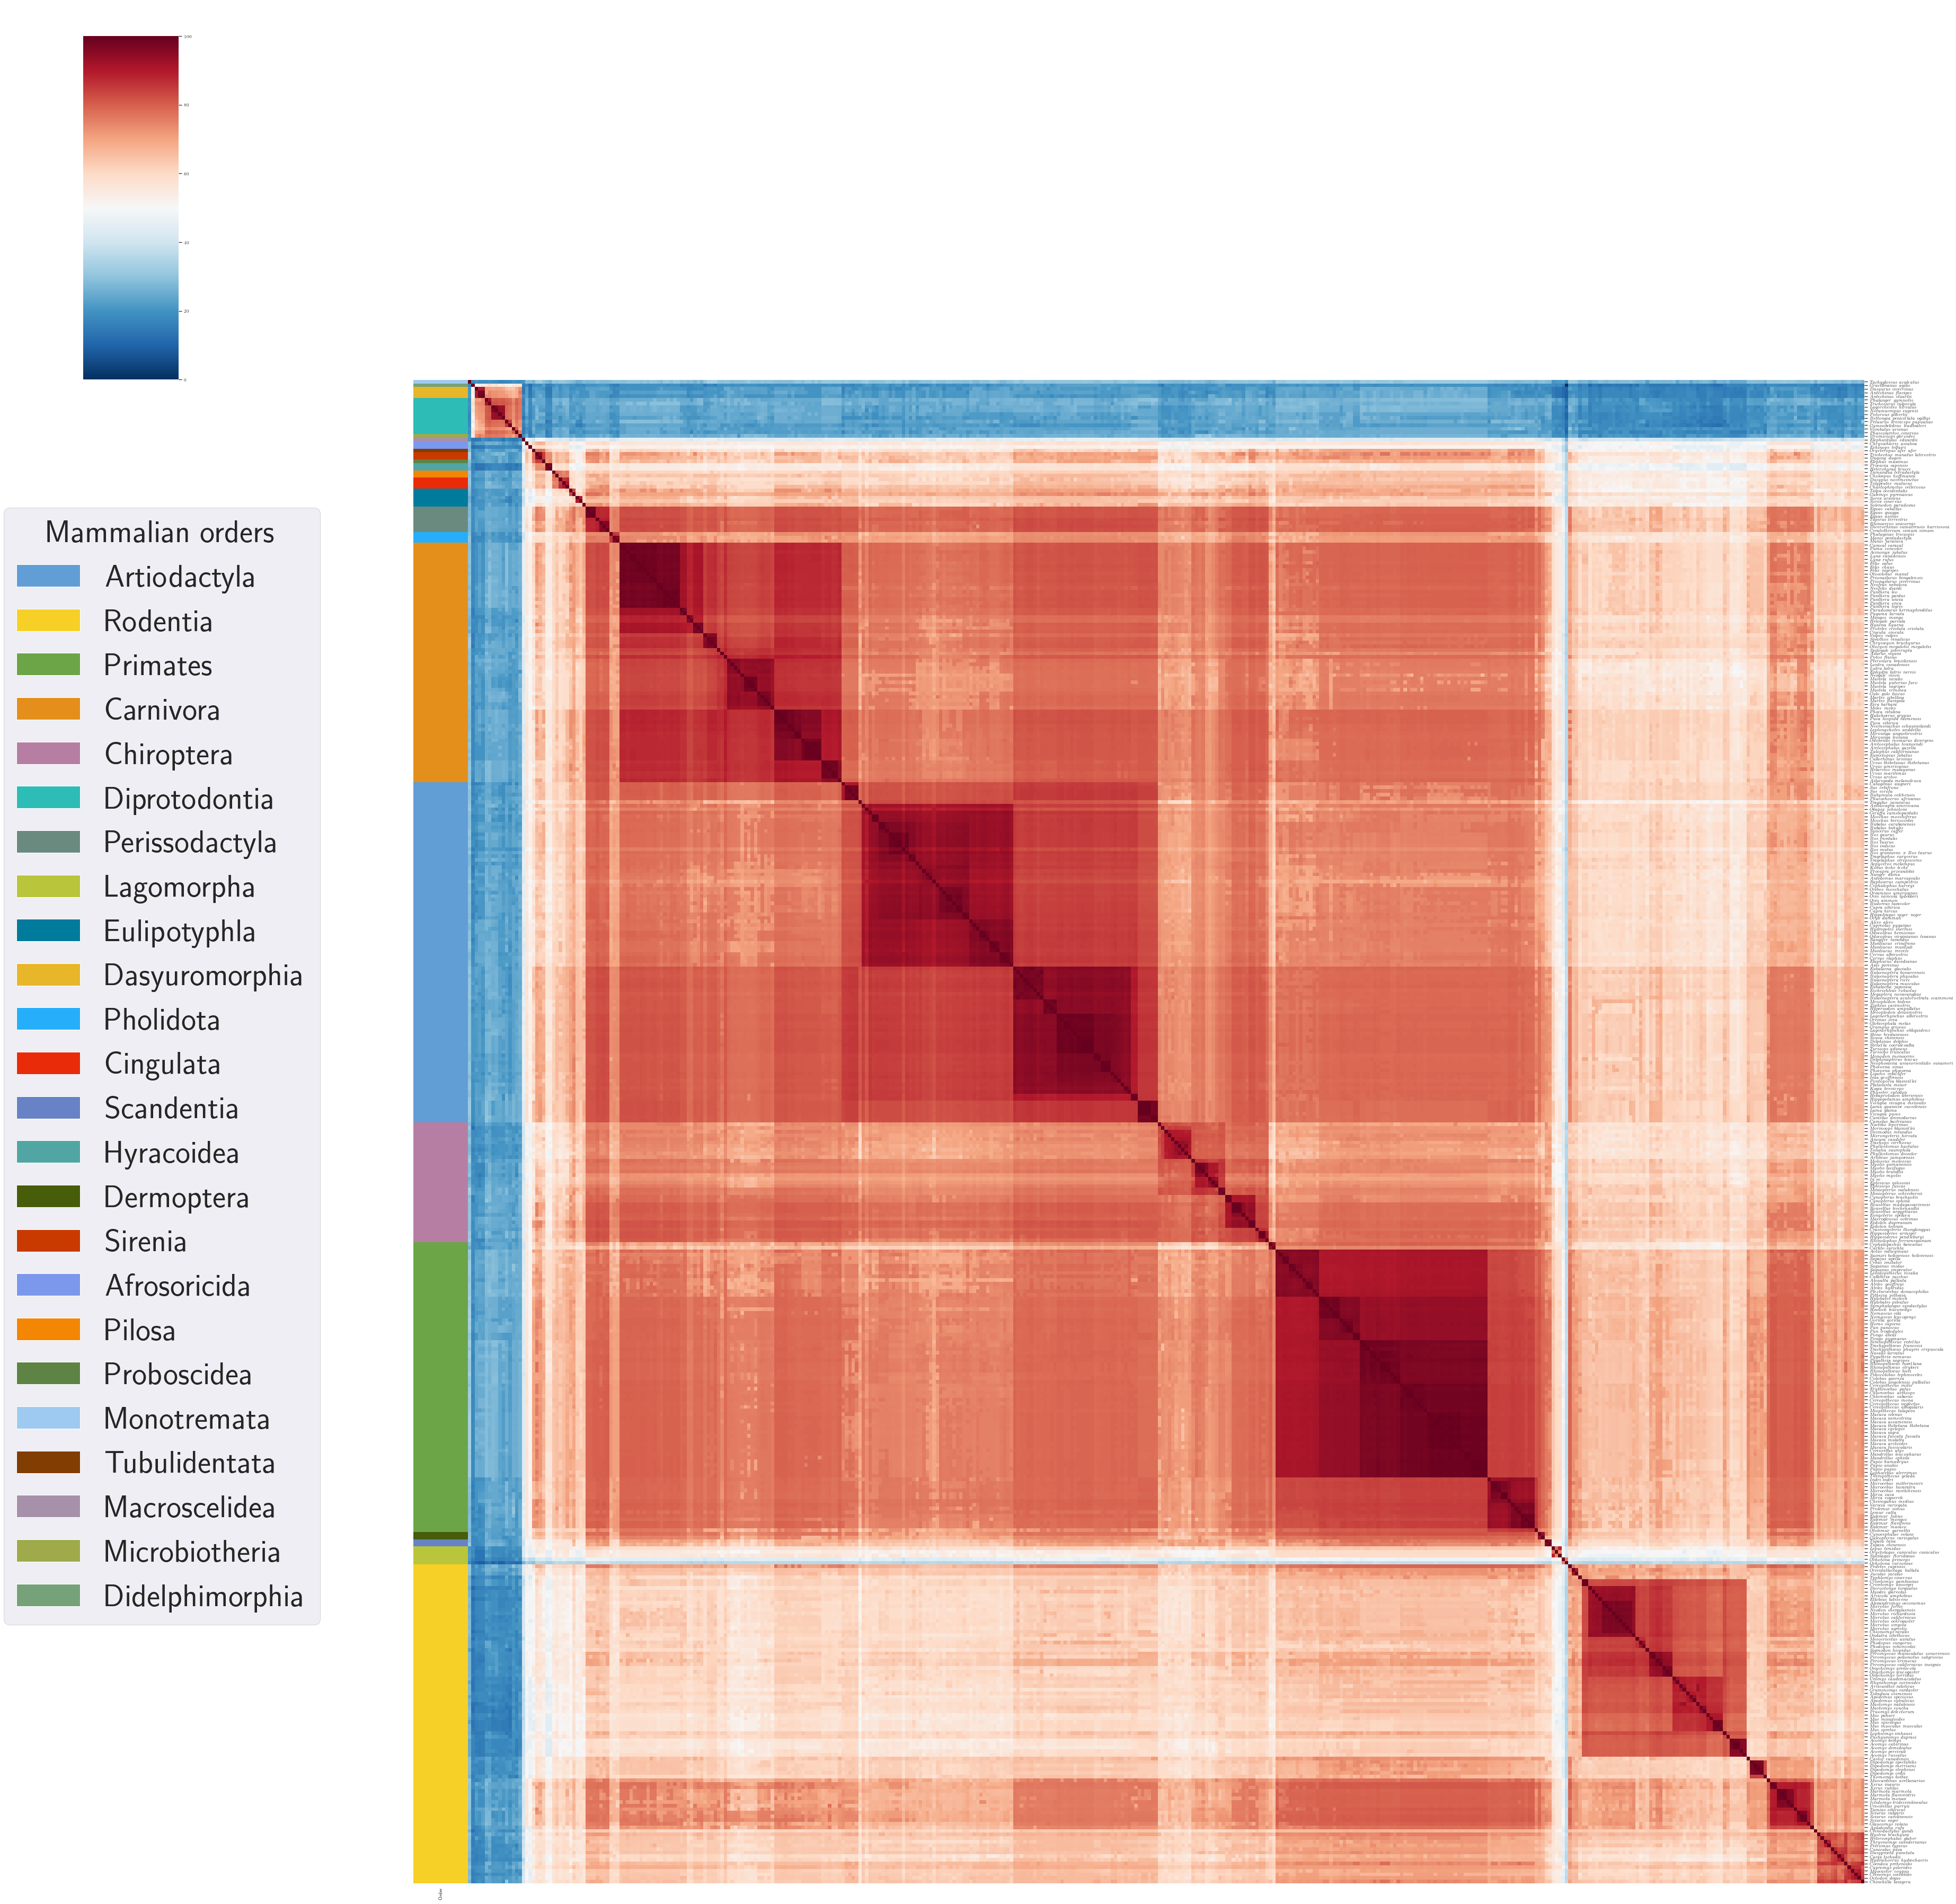

In [81]:
df = pd.DataFrame(matrix)
df_bar = pd.DataFrame([taxa_color]).transpose()
df_bar.set_index = df.columns
df_bar.columns = ['Order']
seaborn.set(font_scale=0.8)
ans = seaborn.clustermap(df,row_cluster=False,col_cluster=False,cmap='RdBu_r',
               annot_kws={"size": 80}, figsize=(50,50), xticklabels=[], yticklabels=latin_list,
                         row_colors=df_bar)
ans.ax_heatmap.set_yticklabels([r'$\it{' + ticklabel.get_text().replace(' ', '\\ ') + '}$'
                              for ticklabel in ans.ax_heatmap.get_yticklabels()])
ans.ax_row_dendrogram.set_visible(False)
handles1 = [Patch(facecolor=taxa_legend[name]) for name in taxa_ordered]
plt.legend(handles1, taxa_ordered, bbox_to_anchor=(-1,-2),title='Mammalian orders', loc='center left',
          fontsize=60, title_fontsize=60)

In [82]:
ans.savefig('./FiguresPublication/MALAT1_ANI_along_phylotree.pdf', dpi=300)

In [84]:
order = [i for i in orderArchetypes if i in malat]
m = []
for item in order:
    l = [dMalat[item][i] for i in order]
    m.append(l)
matrix = np.array(m)

# Species names, ordered
latin_list = [latin[i] for i in order]
names_list = [common[i] for i in order]

#Prepare colors for heatmap

uniqSet = set([tax_order[i].capitalize() for i in order])
taxa_color = [color_map[tax_order[i].capitalize()] for i in order]
taxa_legend = {i:color_map[i] for i in uniqSet}
ordersList = [tax_order[i] for i in order]

#To order legend depending on how many orthologs per taxa, top down

ordersDict = {i:ordersList.count(i) for i in set(ordersList)}
taxa_ordered = sorted(ordersDict.keys(), key=lambda x: ordersDict[x],reverse=True)

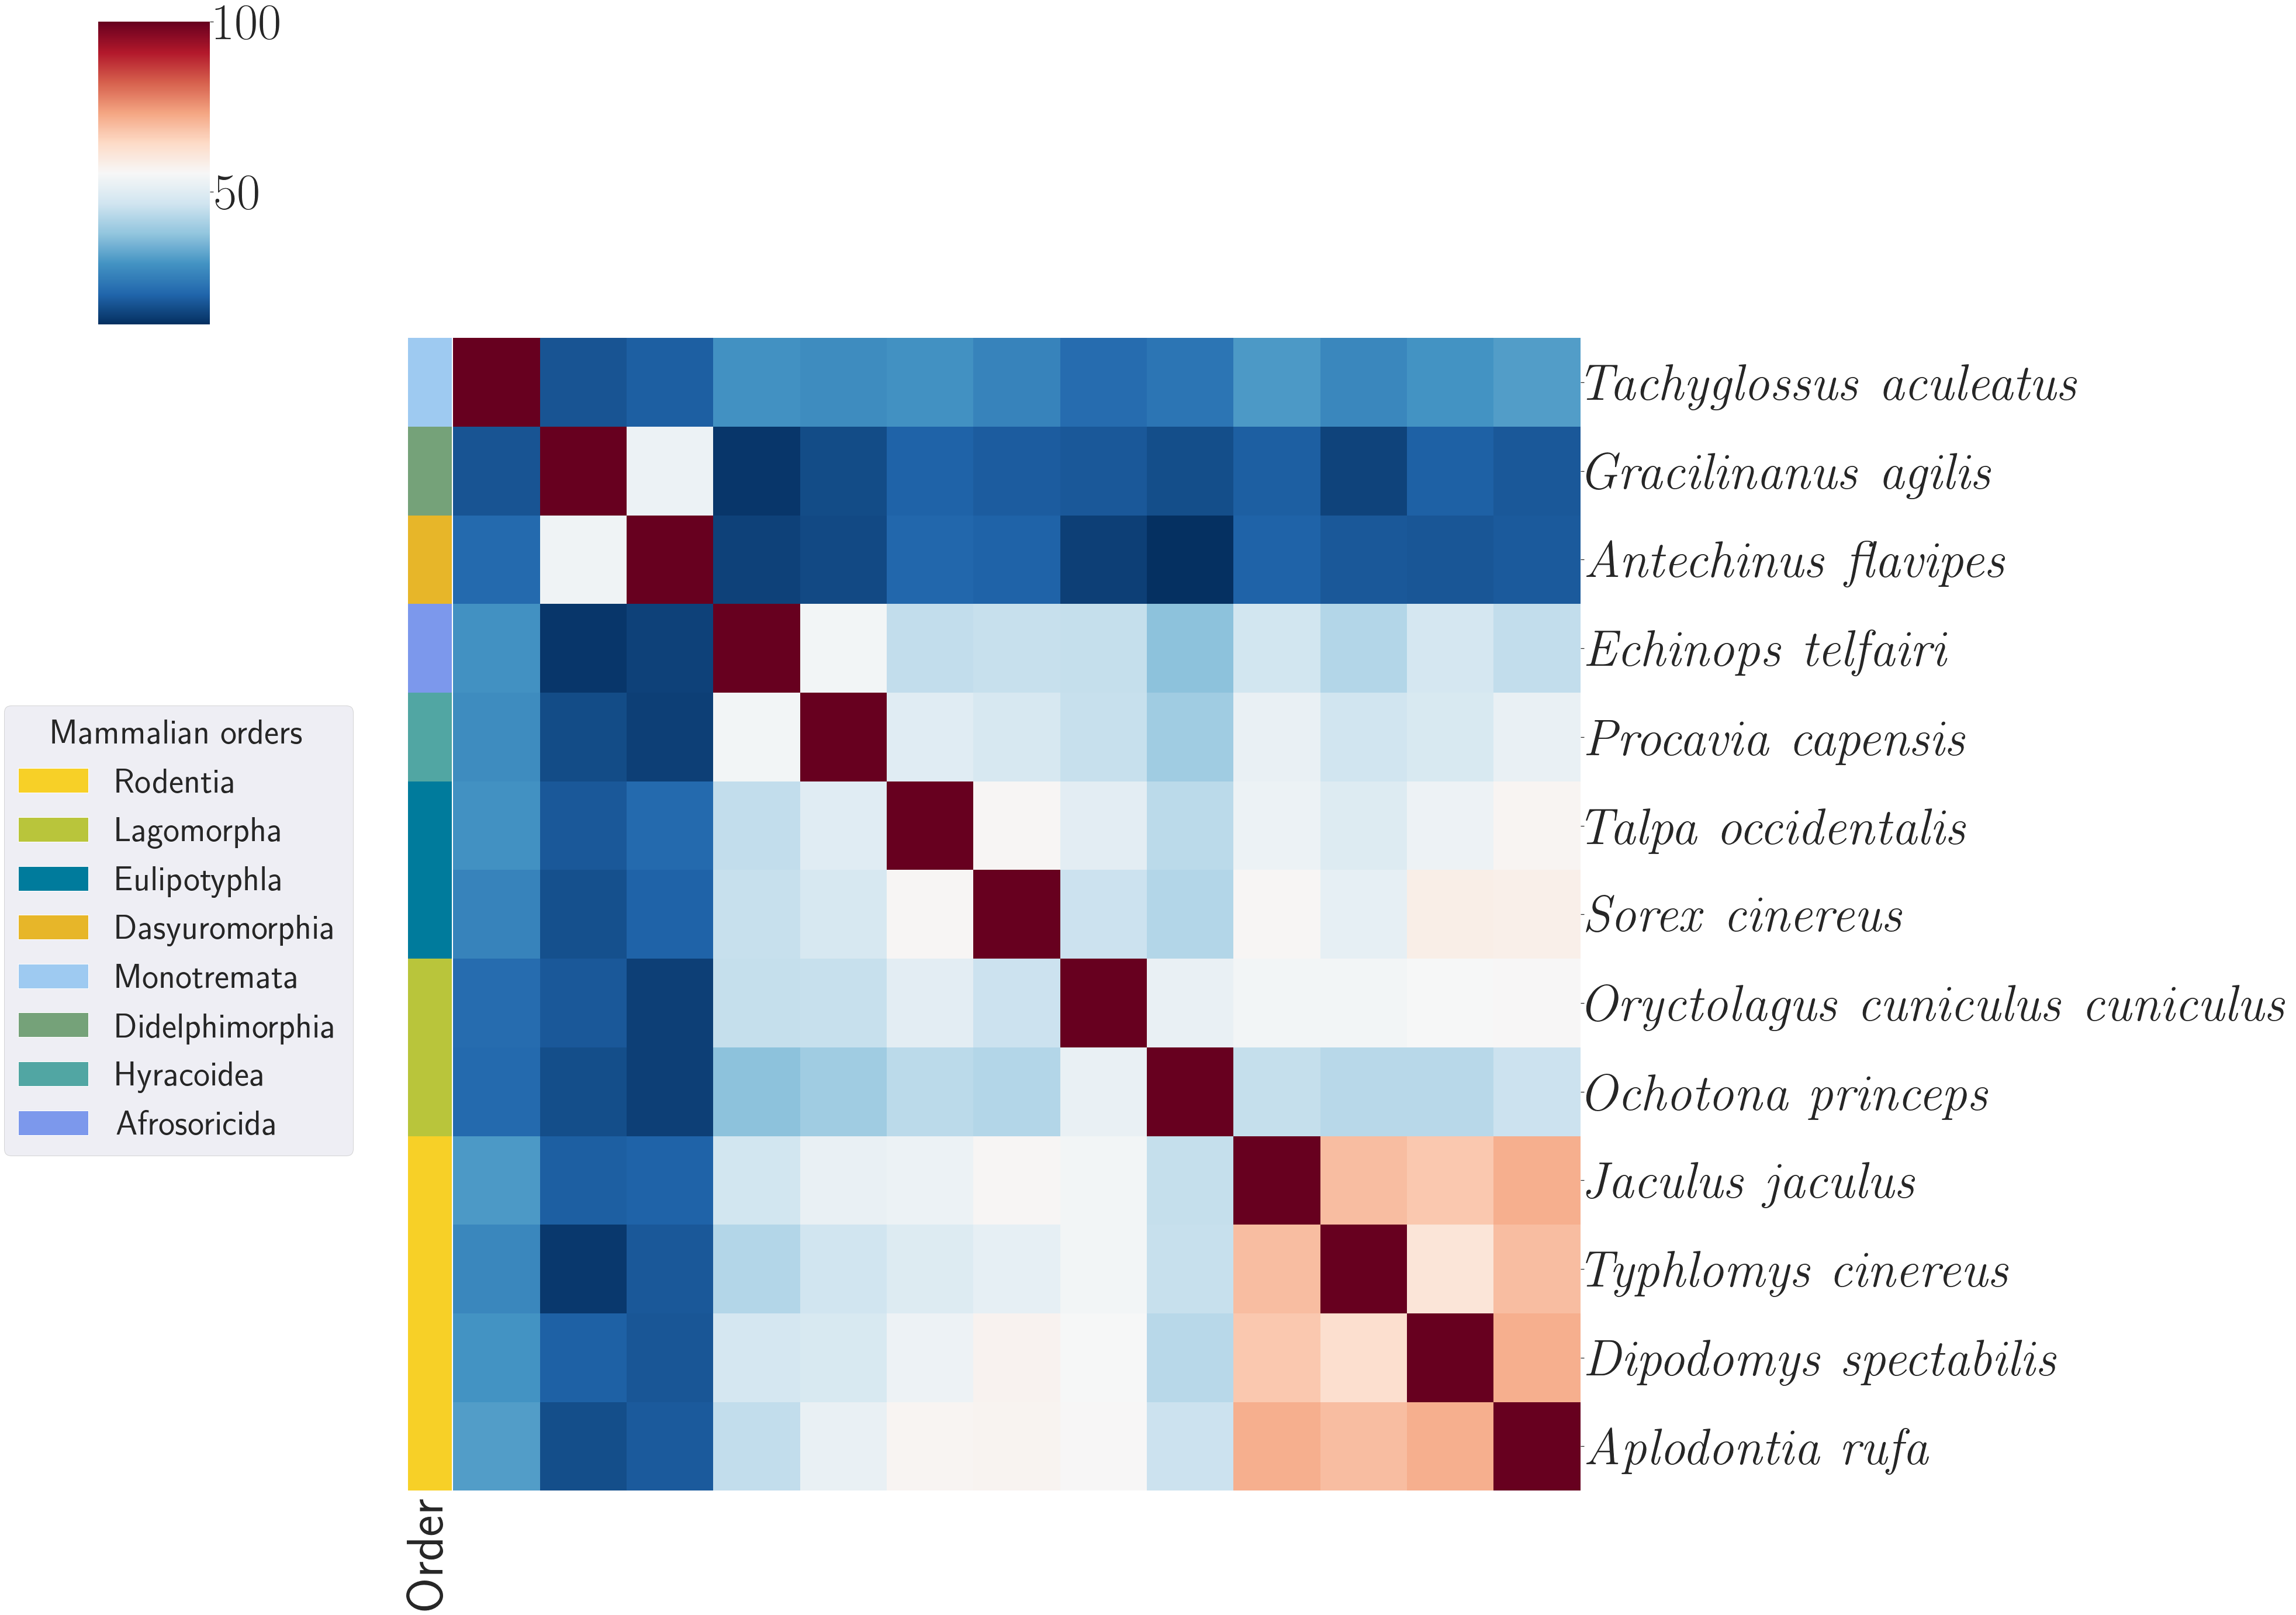

In [85]:
df = pd.DataFrame(matrix)
df_bar = pd.DataFrame([taxa_color]).transpose()
df_bar.set_index = df.columns
df_bar.columns = ['Order']
seaborn.set(font_scale=8)
ans = seaborn.clustermap(df,row_cluster=False,col_cluster=False,cmap='RdBu_r',
               annot_kws={"size": 240}, figsize=(53,40), xticklabels=[], yticklabels=latin_list,
                         row_colors=df_bar)
ans.ax_heatmap.set_yticklabels([r'$\it{' + ticklabel.get_text().replace(' ', '\\ ') + '}$'
                              for ticklabel in ans.ax_heatmap.get_yticklabels()])
ans.ax_row_dendrogram.set_visible(False)
handles1 = [Patch(facecolor=taxa_legend[name]) for name in taxa_ordered]
plt.legend(handles1, taxa_ordered, bbox_to_anchor=(-1,-2),title='Mammalian orders', loc='center left',
          fontsize=60, title_fontsize=60)

In [86]:
ans.savefig('./FiguresPublication/MALAT1_ANI_Archetypes.pdf', dpi=300)